
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021



## Integrantes

*   Laura Natalia González García.
*   Nicolas Gustavo Gaitán Gómez.
*   David Camilo Bonilla Verdugo.



## **Problema**

Ante la situación actual de sanidad pública en el mundo a causa del COVID-19. La detección temprana de esta enfermedad en los pacientes, la automatización de procesos de diagnóstico y el apoyo a los diferentes expertos de esta enfermedad juega un papel muy importante para enfrentar una pandemia el cual ha registrado más de 230 millones de contagios, dejando sin vida a 4 millones de personas alrededor del mundo (OMS, 2021).

Sin embargo, todo este tiempo de cuarentena no solo ha servido para frenar la tasa de contagio del virus. También nos ha permitido recolectar diferentes radiografias de pacientes quienes han sufrido esta enfermedad, junto a otras enfermedades que pueden llegar a tener un una confusión con la enfermedad provocada por el virus. Por ello, es importante determinar con exactitud el tipo de enfermedad para poder recomendar el mejor tratamiento para el paciente.

Se han recolectado alrededor de 21 mil imágenes provenientes de diferentes paises del medio oriente como Catar, Pakistan y Malasia. Y, ante la reactivación económica que se quiere llevar a cabo, se teme una nueva ola de contagios, por lo que poder identificar estos casos dadas sus radiografías autmáticamente, sería de gran ayuda para los trabajadores de la Salud para determinar el tratamiento a los pacientes.

Para eso, le han pedido que construya un modelo capaz de recibir esas imágenes y determinar bajo que probabilidad puede pertenecer a cada una de las clases de las enfermedades proporcionadas. Y así mismo determinar cuál sería el diagnóstico de ese paciente. Como sugerencia, le han pedido construir una Red Neuronal Artificial (ANN) la cual permita realizar este proceso de manera automática y sin supervisión de los expertos en el tema. 

Finalmente, Ante la urgencia del problema, le han pedido que utilicen las imágenes en escala de grises para poder realizar una carga y un almacenamiento de manera más óptima, y utilizar directamente como entrada esta imagen.

**Fuente de Datos:** https://www.kaggle.com/preetviradiya/covid19-radiography-dataset

**Referencias:**

Coronavirus disease (COVID-19) – World Health Organization. (2021). Retrieved 5 October 2021, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019?gclid=Cj0KCQjwwY-LBhD6ARIsACvT72PqduqyNWdB9YQ3awfqyC9FZ1y5Zy7srhp8wrVgEPPmzW4Jgll_Di8aAiDuEALw_wcB


## 1. Importando las librerias requeridas para el desarrollo del laboratorio


In [2]:
import pandas as pd
import numpy as np
import sys
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
#from pandas_profiling import ProfileReport
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import keras_tuner as kt

Tensorflow version: 2.6.0


In [39]:
import os

os.chdir('/home/ubuntu/MLTechniques/Lab3')

## 2. Perfilamiento y entendimiento de los datos

### 2.1 Lectura de los datos
Se leen los metadatos de las imagenes almacenados en la tabla metadata.csv para el entendimiento del formato de las imagenes, su tamaño, y la clase a la que pertenecen

In [3]:
#Carga de metadata de las imágenes
data = pd.read_csv('metadata.csv')
data.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [3]:
#Carga de imágenes
data_dir = "COVID-19_Radiography_Dataset"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print("Total de imagenes en el dataset:",image_count)


Total de imagenes en el dataset: 21165


### 2.2 Entendimiento de los Datos

Para entender la metadata de las imágenes, se realizan 'estadísticas descriptivas'.

In [42]:
ProfileReport(data, minimal= True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Preparación de los datos

Se realiza la separación de los datos de training y de test, en una proporción 80-20 utilizando las imagenes almacenadas en el folder "COVID-19_Radiography_Dataset", el cual contiene 4 folders (que serán las clases) llamados:

- COVID
- Lung_Opacity
- Normal
- Viral Pneumonia

In [4]:
image_size=(299,299)

In [5]:
batch_size = 32
img_height = 299
img_width = 299

train = tf.keras.preprocessing.image_dataset_from_directory(
    "COVID-19_Radiography_Dataset",
    labels='inferred',
    #label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    "COVID-19_Radiography_Dataset",
    labels='inferred',
    #label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)


val_batches = tf.data.experimental.cardinality(val)
test = val.take(val_batches // 2)
val = val.skip(val_batches // 2)


print('Batches para validación: %d' % tf.data.experimental.cardinality(val))
print('Batches para test: %d' % tf.data.experimental.cardinality(test))

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
Batches para validación: 67
Batches para test: 66


In [30]:
class_names = train.class_names
val_class_names = val.class_names
print(class_names)
print(val_class_names)


['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


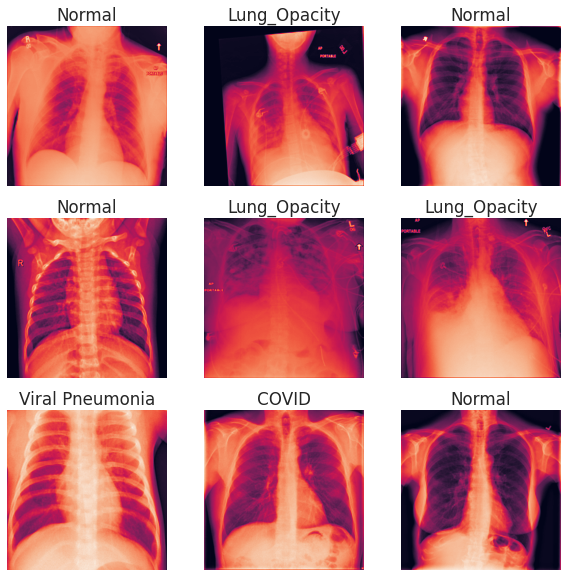

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



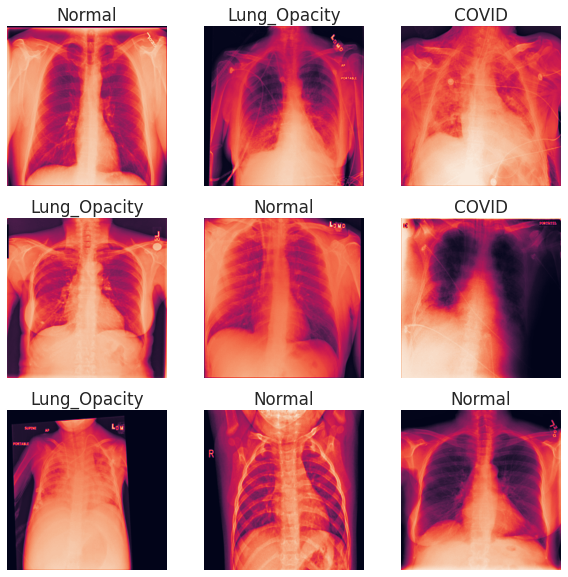

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in val.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Se realiza data-augmentation al dataset para obtener transformaciones aleatorias a las imagenes de forma realista, de tal forma que el modelo se entrene utilizando diferentes imagenes y como un intento de evitar sobreajuste

In [58]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [59]:
augmented_train = train.map(lambda x, y: (data_augmentation(x, training=True), y))


In [60]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)


In [31]:
#Estimación de pesos de las clases en el dataset de entrenamiento
labels=np.concatenate([i for x, i in train], axis=0)

class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels),y=labels)

c_w={}
for i,j in zip(range(4),class_weights):
    c_w[i]=j
    
c_w

{0: 1.456140350877193,
 1: 0.8773056994818653,
 2: 0.5202162959321617,
 3: 3.982126058325494}

## 4. Entrenamiento del modelo

#### 4.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura Multilayer Perceptron estructurada de la siguiente manera:



In [10]:
h_params={"n_layer1":300,"n_layer2":100,"n_layer3":10,"n_layer4":4,"dropout_1":0.2,"dropout_2":0.2,"dropout_3":0.2,
         "dropout_4":0.2}

#Inicialización y construcción de modelo base
model_mlp = keras.models.Sequential([
    #data_augmentation,
    keras.layers.Flatten(input_shape=[299, 299]),
    keras.layers.Dropout(h_params["dropout_1"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer1"], activation="relu"),
    keras.layers.Dropout(h_params["dropout_2"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer2"], activation="relu"),
    keras.layers.Dropout(h_params["dropout_3"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer3"], activation="relu"),
    keras.layers.Dropout(h_params["dropout_4"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer4"], activation="softmax")
])

#Compilamos el modelo usando categorical crossentropy porque es un modelo multietiqueta
model_mlp.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"]) 

In [13]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 89401)             0         
_________________________________________________________________
dropout (Dropout)            (None, 89401)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               26820600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

#### 4.2 Control de complejidad y tiempo de procesamiento
Usaremos 'Early Stopping' para controlar la compljidad y tiempo de procesamiento. Para este caso usaremos como métrica de monitoreo el 'Loss' con paciencia de 3 épocas para verificar que el loss disminuya.

In [33]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

#### 4.3 Fit de modelo base
Corremos el modelo base por 30 epochs con un tamaño de batch de 500 y teninedo en cuenta las diferencias de peso de cada una de las clases

In [52]:
history_mlp = model_mlp.fit(train, epochs=30,batch_size = 500,validation_data=val,class_weight=c_w,callbacks=callbacks)

Epoch 1/30
530/530 [==============================] - 8s 15ms/step - loss: 56.0543 - accuracy: 0.1559 - val_loss: 1.3878 - val_accuracy: 0.0666
Epoch 2/30
530/530 [==============================] - 6s 10ms/step - loss: 7.8704 - accuracy: 0.1697 - val_loss: 1.3864 - val_accuracy: 0.1675
Epoch 3/30
530/530 [==============================] - 6s 10ms/step - loss: 11.2035 - accuracy: 0.1789 - val_loss: 1.3874 - val_accuracy: 0.0666
Epoch 4/30
530/530 [==============================] - 6s 10ms/step - loss: 1.3864 - accuracy: 0.3478 - val_loss: 1.3880 - val_accuracy: 0.0666
Epoch 5/30
530/530 [==============================] - 6s 10ms/step - loss: 1.3865 - accuracy: 0.1304 - val_loss: 1.3875 - val_accuracy: 0.1675
Epoch 6/30
530/530 [==============================] - 6s 10ms/step - loss: 1.3865 - accuracy: 0.3059 - val_loss: 1.3883 - val_accuracy: 0.1675
Epoch 7/30
530/530 [==============================] - 6s 10ms/step - loss: 4.1295 - accuracy: 0.1014 - val_loss: 1.3839 - val_accuracy: 0.16

In [12]:
#Función para generar el reporte del modelo

def get_train_report(history,model,n_epochs):
    epochs = n_epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    from sklearn.metrics import classification_report, confusion_matrix
    y_pred = model.predict(val)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in val], axis=0)

    import seaborn as sns
    cm = confusion_matrix(true_categories, predicted_categories)
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 12},
         cbar = False, cmap='Purples',xticklabels=val_class_names,yticklabels=val_class_names);
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.show()
    
    import os 

    for folder in os.listdir("COVID-19_Radiography_Dataset"):
        print()
        for image in np.random.choice(os.listdir("COVID-19_Radiography_Dataset/"+folder),10):
            true_label=image.split('-')[0]

            img = tf.keras.utils.load_img(
        "COVID-19_Radiography_Dataset/{}/{}".format(folder,image), target_size=(img_height, img_width), color_mode="grayscale")
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0) # Create a batch

            predictions = model_mlp.predict(img_array)

            score = tf.nn.softmax(predictions[0])

            print(
                "{}"
                .format(class_names[np.argmax(score)])
            )
            print(image)


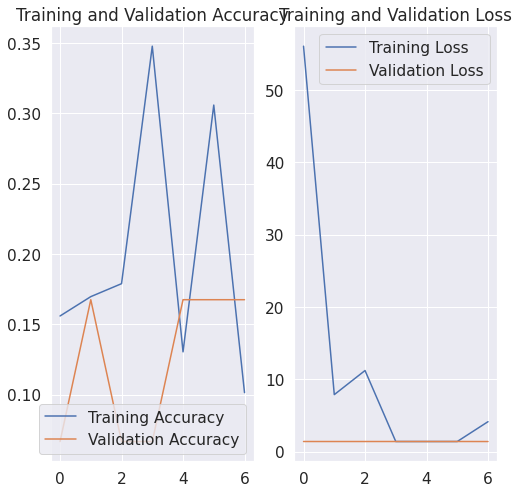

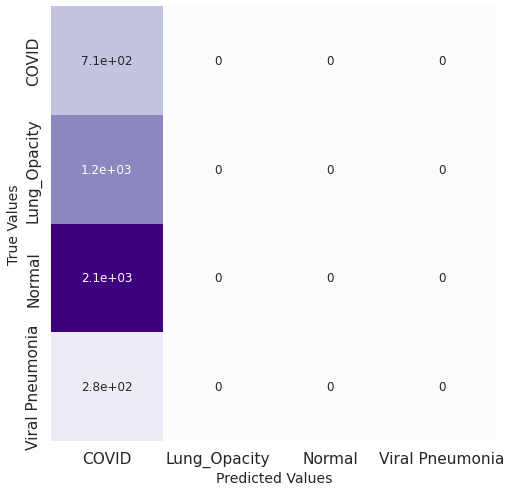


COVID
Lung_Opacity-2626.png
COVID
Lung_Opacity-989.png
COVID
Lung_Opacity-1496.png
COVID
Lung_Opacity-330.png
COVID
Lung_Opacity-1046.png
COVID
Lung_Opacity-5959.png
COVID
Lung_Opacity-3230.png
COVID
Lung_Opacity-4904.png
COVID
Lung_Opacity-4328.png
COVID
Lung_Opacity-3484.png

COVID
Normal-2201.png
COVID
Normal-8073.png
COVID
Normal-7616.png
COVID
Normal-5544.png
COVID
Normal-10093.png
COVID
Normal-6112.png
COVID
Normal-4623.png
COVID
Normal-6387.png
COVID
Normal-6840.png
COVID
Normal-3881.png

COVID
Viral Pneumonia-106.png
COVID
Viral Pneumonia-143.png
COVID
Viral Pneumonia-180.png
COVID
Viral Pneumonia-116.png
COVID
Viral Pneumonia-236.png
COVID
Viral Pneumonia-1279.png
COVID
Viral Pneumonia-434.png
COVID
Viral Pneumonia-472.png
COVID
Viral Pneumonia-1107.png
COVID
Viral Pneumonia-1047.png

COVID
COVID-1656.png
COVID
COVID-2965.png
COVID
COVID-2578.png
COVID
COVID-98.png
COVID
COVID-2948.png
COVID
COVID-2024.png
COVID
COVID-3030.png
COVID
COVID-928.png
COVID
COVID-2380.png
COVID
CO

In [55]:
get_train_report(history_mlp,model_mlp,7)

#### 4.4 Búsqueda de hiperparámetros

In [35]:
def build_model(hp):
    model = Sequential(name='CovidNet')
    model.add(layers.Flatten(input_shape=[299, 299]))
    model.add(Dense(
                units=hp.Int('units', min_value=100, max_value=10000, step=100),
                activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'],default='relu'),
                name='Capa_Entrada'))
    model.add(Dropout(hp.Choice('dropout',[0.1,0.2,0.3]),name='Dropout_0'))
    for i in range(hp.Int("num_layers", 0, 3)):
        model.add(Dense(
                units=hp.Int("units", min_value=100, max_value=10000, step=100),
                activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'],default='relu'),
                name= 'Capa_Oculta_{0}'.format(i)))
        model.add(Dropout(hp.Choice('dropout',[0.1,0.2,0.3]),name='Dropout')) 
        
    model.add(Dense(4, activation="softmax",name= 'Capa_Salida'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [36]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    seed=1234,
    overwrite=True)
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 10000, 'step': 100, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
tuner.search(train, epochs=30,batch_size = 500,validation_data=val,class_weight=c_w,callbacks=callbacks)


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
tuner.results_summary()

## 5. Validación